In [27]:
%run ./Definitions.ipynb

2019-12-04 09:33:55.936361
thunder  Wed Dec  4 09:33:58 2019
[0] GeForce GTX 1080 Ti | 41'C,   0 % |  8605 / 11178 MB | patra(8595M)
[1] GeForce GTX 1080 Ti | 61'C, 100 % | 10936 / 11178 MB | david(10926M)
[2] GeForce GTX 1080 Ti | 29'C,   0 % |  8605 / 11178 MB | patra(8595M)
[3] GeForce GTX 1080 Ti | 66'C, 100 % | 10936 / 11178 MB | david(10926M)
[4] GeForce GTX 1080 Ti | 26'C,   0 % |  8605 / 11178 MB | patra(8595M)
[5] GeForce GTX 1080 Ti | 41'C,   0 % | 10780 / 11178 MB | david(10770M)
[6] GeForce GTX 1080 Ti | 32'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 30'C,   0 % |  8605 / 11178 MB | patra(8595M)
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "4"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Wed Dec  4 06:21:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 50%   62C    P2   200W / 250W |  10936MiB / 11178MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 56%   71C    P2   125W / 250W |  10936MiB / 11178MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 3 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 661
No. of non-Glaucoma patients in training set: 101173


### 1. Over Sampling

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]=='0']
glaucoma = X[X[Class]=='1']

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# Converting class values to int 1 or 0
upsampled[Class] = upsampled[Class].astype(int)

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
upsampled[Class].value_counts()

1    101173
0    101173
Name: GTi, dtype: int64

In [9]:
valid_valdf_names[Class].value_counts()

0    33733
1      210
Name: GTi, dtype: int64

## Define Model and Metrics

In [10]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:81]:
        layer.trainable = False
    for layer in mobile_conv.layers[81:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
    
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [11]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [12]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, rescale= 1./255) 
val_datagen = ImageDataGenerator(rescale=1./255)  
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)


Found 202346 validated image filenames.
Found 33943 validated image filenames.


In [13]:
# which_model = make_model
which_model = mobilenet_model
# which_model = vgg_model
model = which_model()

learning_rate  = 0.001 
decay = 1e-5
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,062,913
Non-trainable params: 2,166,976
_________________________________________________________________


In [14]:
# With L2 weight regularizer
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)
keras_model_path = funduspath_CR + 'Models/'
n_epochs=150
n_steps_per_epoch = 50
n_validation_steps = 10

In [15]:
start = time.time()
history = model.fit_generator(train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/150
50/50 [==============================] - 44s 882ms/step - loss: 0.8077 - Accuracy: 0.6225 - Precision: 0.6367 - Recall: 0.6168 - F1: 0.6103 - AUC: 0.6755 - val_loss: 0.8271 - val_Accuracy: 0.6031 - val_Precision: 0.0155 - val_Recall: 0.2000 - val_F1: 0.0287 - val_AUC: 0.7739
Epoch 2/150
50/50 [==============================] - 35s 702ms/step - loss: 0.6301 - Accuracy: 0.7069 - Precision: 0.7180 - Recall: 0.7395 - F1: 0.7194 - AUC: 0.7716 - val_loss: 1.5481 - val_Accuracy: 0.0844 - val_Precision: 0.0031 - val_Recall: 0.1000 - val_F1: 0.0061 - val_AUC: 0.9577
Epoch 3/150
50/50 [==============================] - 41s 817ms/step - loss: 0.5820 - Accuracy: 0.7262 - Precision: 0.7299 - Recall: 0.7592 - F1: 0.7381 - AUC: 0.7832 - val_loss: 0.1222 - val_Accuracy: 0.9969 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6928
Epoch 4/150
50/50 [==============================] - 41s 826ms/step - loss: 0.5397 - Accuracy: 0.7362 - Precision: 0.7361 - 

Epoch 28/150
50/50 [==============================] - 38s 763ms/step - loss: 0.2807 - Accuracy: 0.8900 - Precision: 0.8749 - Recall: 0.9146 - F1: 0.8896 - AUC: 0.9590 - val_loss: 0.4094 - val_Accuracy: 0.8094 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4466
Epoch 29/150
50/50 [==============================] - 39s 789ms/step - loss: 0.3017 - Accuracy: 0.8806 - Precision: 0.8590 - Recall: 0.9055 - F1: 0.8769 - AUC: 0.9496 - val_loss: 0.3085 - val_Accuracy: 0.9094 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4117
Epoch 30/150
50/50 [==============================] - 39s 787ms/step - loss: 0.2999 - Accuracy: 0.8794 - Precision: 0.8546 - Recall: 0.9188 - F1: 0.8787 - AUC: 0.9481 - val_loss: 0.1381 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8373
Epoch 31/150
50/50 [==============================] - 37s 742ms/step - loss: 0.3072 - Accuracy: 0


Epoch 00054: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 55/150
50/50 [==============================] - 37s 738ms/step - loss: 0.2874 - Accuracy: 0.8838 - Precision: 0.8618 - Recall: 0.9213 - F1: 0.8841 - AUC: 0.9571 - val_loss: 0.2575 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5952
Epoch 56/150
50/50 [==============================] - 35s 709ms/step - loss: 0.2786 - Accuracy: 0.8938 - Precision: 0.8780 - Recall: 0.9256 - F1: 0.8965 - AUC: 0.9583 - val_loss: 0.2473 - val_Accuracy: 0.8906 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7634
Epoch 57/150
50/50 [==============================] - 34s 674ms/step - loss: 0.2713 - Accuracy: 0.9056 - Precision: 0.8776 - Recall: 0.9424 - F1: 0.9058 - AUC: 0.9620 - val_loss: 0.3869 - val_Accuracy: 0.9156 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5661
Epoch 58/150
50/50 [============

50/50 [==============================] - 36s 724ms/step - loss: 0.2757 - Accuracy: 0.8944 - Precision: 0.8728 - Recall: 0.9303 - F1: 0.8949 - AUC: 0.9607 - val_loss: 0.2307 - val_Accuracy: 0.9062 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 83/150
50/50 [==============================] - 37s 749ms/step - loss: 0.2538 - Accuracy: 0.9137 - Precision: 0.8926 - Recall: 0.9421 - F1: 0.9134 - AUC: 0.9716 - val_loss: 0.2035 - val_Accuracy: 0.9094 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4716
Epoch 84/150
50/50 [==============================] - 34s 681ms/step - loss: 0.2573 - Accuracy: 0.9087 - Precision: 0.8814 - Recall: 0.9430 - F1: 0.9080 - AUC: 0.9697 - val_loss: 0.4064 - val_Accuracy: 0.8938 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3438
Epoch 85/150
50/50 [==============================] - 34s 687ms/step - loss: 0.2863 - Accuracy: 0.8944 - P

50/50 [==============================] - 35s 696ms/step - loss: 0.2750 - Accuracy: 0.9019 - Precision: 0.8863 - Recall: 0.9363 - F1: 0.9072 - AUC: 0.9612 - val_loss: 0.2968 - val_Accuracy: 0.9125 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8809
Epoch 110/150
50/50 [==============================] - 37s 749ms/step - loss: 0.2629 - Accuracy: 0.8994 - Precision: 0.8806 - Recall: 0.9255 - F1: 0.8990 - AUC: 0.9677 - val_loss: 0.3149 - val_Accuracy: 0.9000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6435
Epoch 111/150
50/50 [==============================] - 37s 748ms/step - loss: 0.2807 - Accuracy: 0.8931 - Precision: 0.8570 - Recall: 0.9393 - F1: 0.8916 - AUC: 0.9601 - val_loss: 0.1425 - val_Accuracy: 0.8844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.2508
Epoch 112/150
50/50 [==============================] - 36s 720ms/step - loss: 0.2818 - Accuracy: 0.8931 - Pr

50/50 [==============================] - 36s 723ms/step - loss: 0.2652 - Accuracy: 0.9112 - Precision: 0.9001 - Recall: 0.9303 - F1: 0.9109 - AUC: 0.9642 - val_loss: 0.4899 - val_Accuracy: 0.8656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6383
Epoch 137/150
50/50 [==============================] - 35s 704ms/step - loss: 0.2819 - Accuracy: 0.8950 - Precision: 0.8726 - Recall: 0.9297 - F1: 0.8957 - AUC: 0.9583 - val_loss: 0.2251 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7193
Epoch 138/150
50/50 [==============================] - 37s 734ms/step - loss: 0.2752 - Accuracy: 0.9025 - Precision: 0.8886 - Recall: 0.9246 - F1: 0.9037 - AUC: 0.9619 - val_loss: 0.2008 - val_Accuracy: 0.9156 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 139/150
50/50 [==============================] - 36s 719ms/step - loss: 0.2657 - Accuracy: 0.9069 

In [17]:
print("Time taken:",end-start)

Time taken: 5477.121284008026


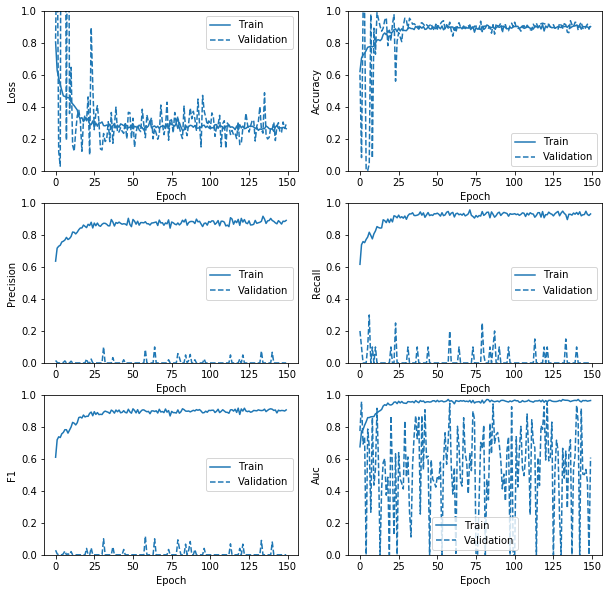

In [18]:
plt.figure(figsize=(10,10))
plot_metrics(history)

## Evaluation

In [19]:
results_tr = model.evaluate(train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 14s 145ms/step


In [20]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))


NAME :	TRAIN :	VALIDATION 
loss : 0.734 :   0.183
Accuracy : 0.563 :   0.903
Precision : 0.547 :   0.005
Recall : 0.752 :   0.015
F1 : 0.627 :   0.007
AUC : 0.608 :   0.662


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [21]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(4378.7588748931885, 154.22931623458862)

In [22]:
# TRUE LABELS

train_labels = upsampled[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


In [24]:
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_tr_81unfreze.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_vl_81unfreze.npy', pred_vl)

### ROC Curve

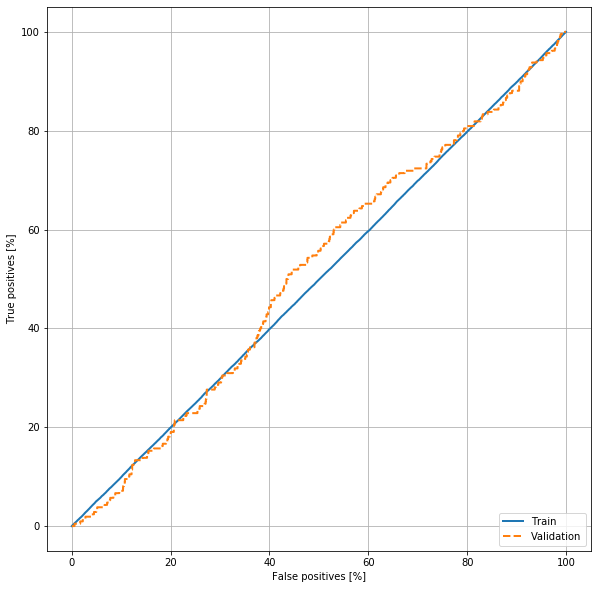

In [25]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 32062 
FP: 69111 
FN: 32190 
TP: 68983
Healthy Patients - correctly identified (True Negatives):  32062 0.3169027309657715
Healthy Patients - predicted to have glaucoma (False Positives):  69111 0.6830972690342285
Glaucoma Patients - predicted healthy (False Negatives):  32190 0.3181678906427604
Glaucoma Patients - correctly identified (True Positives):  68983 0.6818321093572396

Total Glaucoma patients:  101173 1.0
Total Healthy patients:  101173 1.0


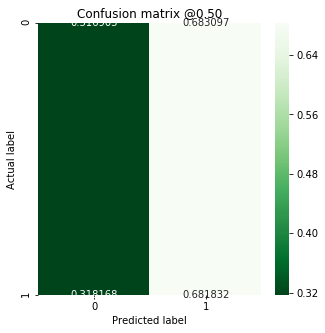

In [28]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 30752 
FP: 2981 
FN: 196 
TP: 14
Healthy Patients - correctly identified (True Negatives):  30752 0.9116295615569324
Healthy Patients - predicted to have glaucoma (False Positives):  2981 0.08837043844306762
Glaucoma Patients - predicted healthy (False Negatives):  196 0.9333333333333333
Glaucoma Patients - correctly identified (True Positives):  14 0.06666666666666667

Total Glaucoma patients:  210 1.0
Total Healthy patients:  33733 1.0


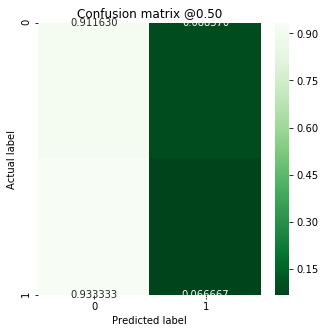

In [29]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [30]:
exp_name = 'GAP_150_unfreeze'
keras_model_path = funduspath_CR+ exp_name + '_model'
save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
            n_epochs,n_steps_per_epoch,n_validation_steps,
            reg_value,learning_rate,decay,opt,
            history,results_tr,results_vl,train_cm,val_cm
           )